# CS413 Image and Video Analysis -- Lab 5

## Department of Computer Science, University of Warwick
## July, 2019

## Aims:

The aims of this lab are to

+ Learn how to read, display and write video data in Python and OpenCV
+ Perform some simple data manipulations on video data frames
+ Use frame-differencing and moving average models to estimate locations of moving objects in videos
+ Implement a Gaussian model for foreground/background separation in videos
+ Learn what are the effects of changing parameters of a Guassian background model 
+ Use the OpenCV Mixture of Gaussians (MOG) background estimation method to find bounding boxes of
multiple moving objects in a video


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 # this imports OpenCV functions

# we can find out which version of OpenCV we are using like this
print('Using OpenCV version ', cv2.__version__)


Using OpenCV version  4.1.1


## Reading, Display and Writing video frames

Video data consists of frames of images which are encoded in a variety of different ways, e.g. AVI, MP4. MOV. 
OpenCV has methods to read and write frames from most popular video formats.

We can use the OpenCV `VideoCapture.read()` and `VideoWriter` to read and write video frames in to and from `numpy` arrays.

Look at the two methods below `read_frames` and `write_frames`. 

Note that

1. The `read_frames` method assumes that the input frames are encoded BGR colour channel order, so it does a 
flip of the colour channels so that they are in RGB order.

2. The `write_frames` method always makes a H.264 compatible video format file. 

Execute the cell with the function definitions.

In [2]:


def read_frames(filename):
    video_cap = cv2.VideoCapture(filename)

    count = 0
    frames = []
    while True:
        success, frame = video_cap.read()

        if success:
            count += 1
            
            # convert from BGR to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)
        else:
            # print('Failed to read frame') # when last frame read
            break;


    print('Read ', count, ' frames in total')
    video_cap.release()
    
    return frames

def write_frames(frames, filename):
    
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') # 'MP4V'
    writer = cv2.VideoWriter(filename, fourcc, 24, (frames[0].shape[1],frames[0].shape[0]), True)

    for i in range(0,len(frames)):

        frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)

        writer.write(frame)

    
    writer.release()


###  Loading movies as a list of frames

In the following, we will load a sequence (`pedestrians.mp4`) and look at the first frame.

The sequence is loaded into a list of `numpy` arrays.

In [3]:
data_dir = '/modules/cs413/data/' # your data directory!


frames = read_frames(data_dir + 'pedestrians.mp4')

Read  379  frames in total


### Display frame by frame using `pyplot.imshow()`

The simplest way to display the movie frames is to use `matplotlib.pyplot.imshow()` like this:

Each frame has shape  (480, 640, 3)
nbAgg


<IPython.core.display.Javascript object>


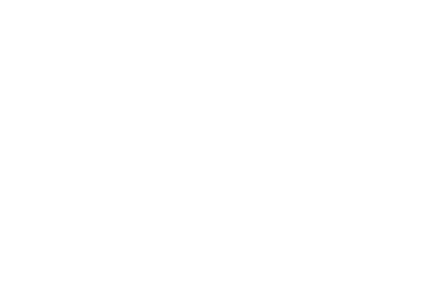

<IPython.core.display.Javascript object>


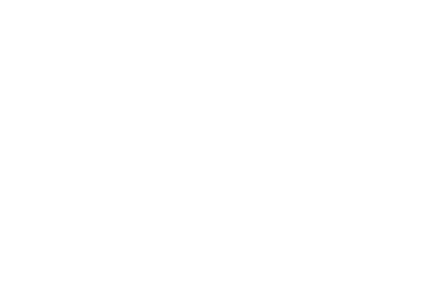

In [25]:
print('Each frame has shape ', frames[0].shape)

# display the first frame (frame[0])
print(plt.get_backend())
plt.imshow(frames[0])
plt.axis('off')
plt.show()

### Animating a set of frames embedded in a notebook

It is possible to animate frames using `pyplot.imshow()` (but not easy!). 

I've written a function `plot_movie` to do this but to use it you need to tell `matplotlib`
to use a the `nbAgg` renderer (rather than the default). So at the start of the cell we need to add
the command

~~~~
%matplotlib nagg
~~~~

This is unfortunate, as Jupyter will then continue to use this renderer until you switch back to the default:
    
~~~~
%matplotlib inline
~~~~

Also, this behaviour is quite buggy so expect the notebook to crash from time to time :(

<IPython.core.display.Javascript object>


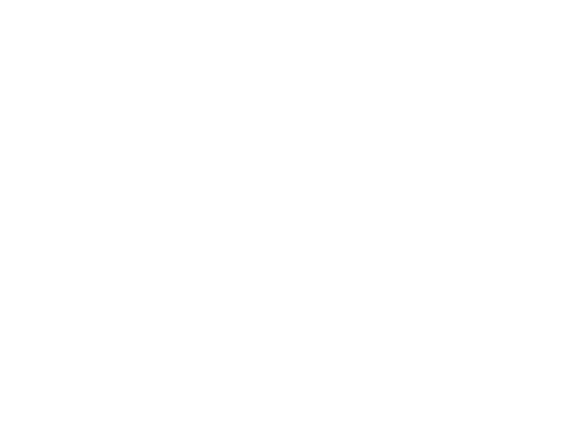

<IPython.core.display.Javascript object>


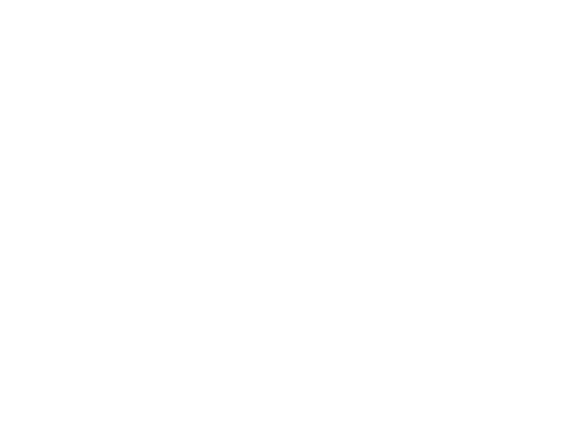

Traceback (most recent call last):
  File "/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [24]:
%matplotlib nbagg
import matplotlib.animation

def plot_movie(ax, frames, interval=1, vmin=0, vmax=255): 

    ax = plt.imshow(frames[0], vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title('My movie')
    
    animate = lambda i: ax.set_data(frames[i])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval=interval, blit=False)

    return ani # keep the animator persistant

# to plot all the frames of our movie we can use the following

fig, ax = plt.subplots(figsize=(8,6))
ani = plot_movie(ax, frames) # we have to keep an handle to the pyplot animator


### Writing frames to a file

Another way to visualise our results is to simply write out the file to a MP4 or H264 format movie file and 
use your desktop or laptop applications to view the movie.

Here's how to use my `write_frames()` function. Check that the file appears somewhere on your own machine and
see if you can view it using another application.


In [62]:
%matplotlib inline

filename = 'foo.mp4'

write_data_dir = '/dcs/16/u1606521/year4/cs413' # some folder where you want to save the file
write_frames(frames,  write_data_dir + filename)

### HTML5 movie viewer in Jupyter

We can embed an HTML5 viewer into a notebook to view movies. This can be useful sometimes.

Here's how you might do it.

In [4]:
import io
import base64

from IPython.display import HTML

#video = io.open('/Users/abhir/Desktop/data/roundabout.mp4', 'r+b').read()
video = io.open('/Users/abhir/Desktop/foo.mp4', 'r+b').read()

encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/abhir/Desktop/foo.mp4'

## Background subtraction: Frame Differencing

OK, now we know the basics of how to load, display and save movie frames, let's turn to 
some video analysis.

Background modelling or foreground separation is the process of identifying moving objects 
within a movie. One way to do this is build a model of the background of the scene
and subtract it from each successive frame. 

The assumption is that the camera is not moving and there is not too much noise (like data compression artifacts).
As we will see, these things cause problems in estimating locations of moving foreground objects.



### RGB to Grayscale

Before we start, here's how to convert a RGB frame to a gray-scale. This will be useful to 
do the background modelling. We can use the OpenCV `cvtColor()` function.
~~~~
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
~~~~

## Frame Differencing

### Exercises 1

1. Write a loop to convert the set of input image frames `frames` to grayscale. Store the result in a new
list, `frames_g`.

2. Do frame differencing over all the frames storing the result in a new list, `diffs`.
~~~~
    diff = frame_g[i+1] - frame_g[i]
~~~~
Note, you may want to convert the frames to type `float` before doing the subtraction.

3. Use `pyplot.imshow()` to display differences 0, 50, and 100 for the `pedestrians` sequence.


Read  379  frames in total
(480, 640)


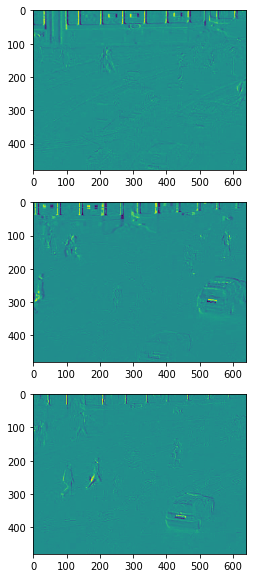

In [5]:
frames = read_frames("/dcs/16/u1606521/year4/cs413/data/foo.mp4")
gframes = frames.copy()
diffs = gframes.copy()
for a in range(len(frames)):
    gframes[a] = cv2.cvtColor(frames[a], cv2.COLOR_BGR2GRAY)
    
for b in range(len(gframes)-1):
    diffs[b] = gframes[b+1].astype(float)-gframes[b].astype(float)
    
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(diffs[0])
plt.subplot(3,1,2)
plt.imshow(diffs[50])
plt.subplot(3,1,3)
plt.imshow(diffs[100])
print(diffs[100].shape)
#write_frames(diff,"/dcs/16/u1606521/year4/cs413/data/difffoo.mp4")
#write_frames(gframes,"/dcs/16/u1606521/year4/cs413/data/grayfoo.mp4")

<IPython.core.display.Javascript object>


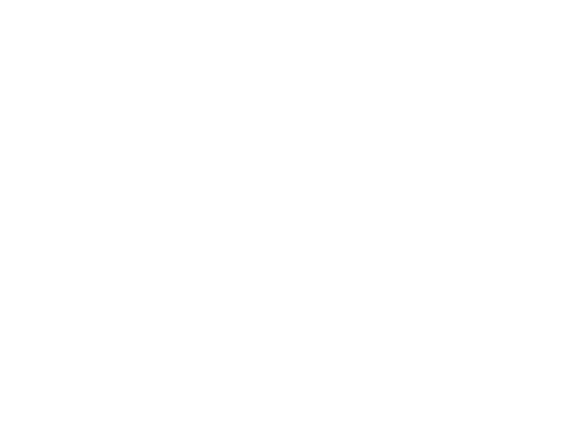

<IPython.core.display.Javascript object>


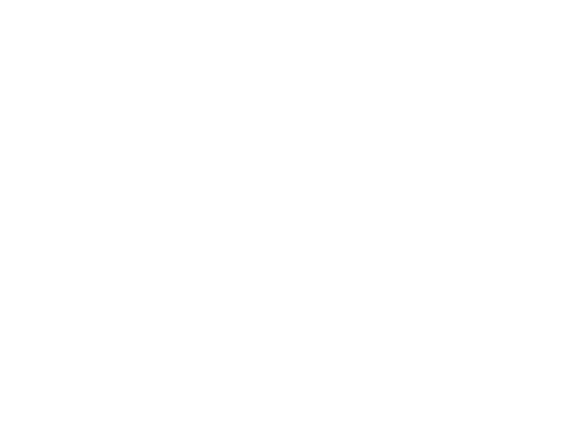

Traceback (most recent call last):
  File "/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [60]:
%matplotlib nbagg

# this is how you might show your frame differences as a movie
fig, ax = plt.subplots(figsize=(8,6))

ani = plot_movie(ax, diffs, interval=50)


## Running Average Models

To build a model of the background, if the assume the camera is stationary, we can average
consecutive frames (over a buffer). The learning rule can help:
$$
    B(t) = \alpha  f(t) + (1 - \alpha) B(t-1)
$$
where $ B(t) $ is the current average, $ t $ is the frame number, $ \alpha $ is some value in range $ [0,1] $.

### Exercises 2

1. Implement the running average model. You will want to save the running-average in a variable
defined as zeros outside a loop, e.g.

~~~~
    running_average = np.zeros(frames[0].shape) # frames should be grayscale
    
    averages = []  # you don't need this but it's interesting to see how they change
    for i in range(len(frames)):
        running_avg = ...
        
        averages.append(running_avg)
       
~~~~

2. Display the running average at frames 0, 50, 100 for $ \alpha = 0.1 $. Experiment with different values of $ \alpha $.

3. Use the running avarge $ B(t) $ to estimate the foreground. Display the foreground at frames 0, 50 and 100.

4. Write the foregrounds to a movie file and play this movie (either embedded in the notebook or using an external viewer).

(480, 640)


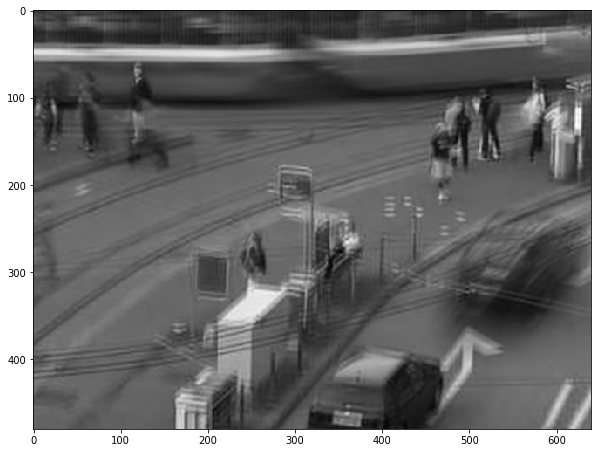

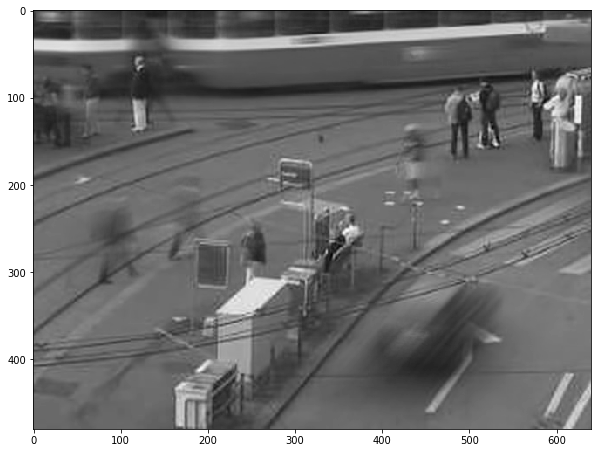

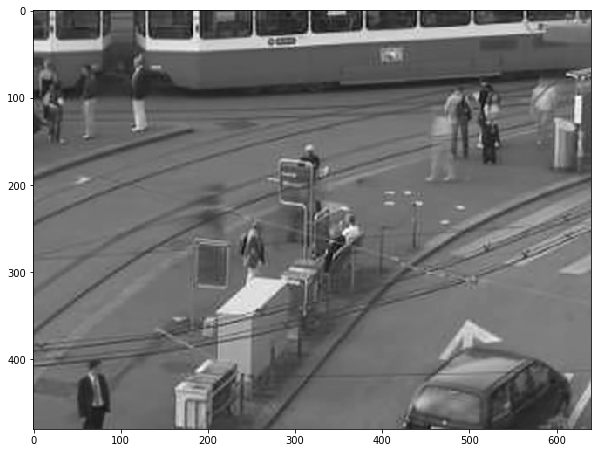

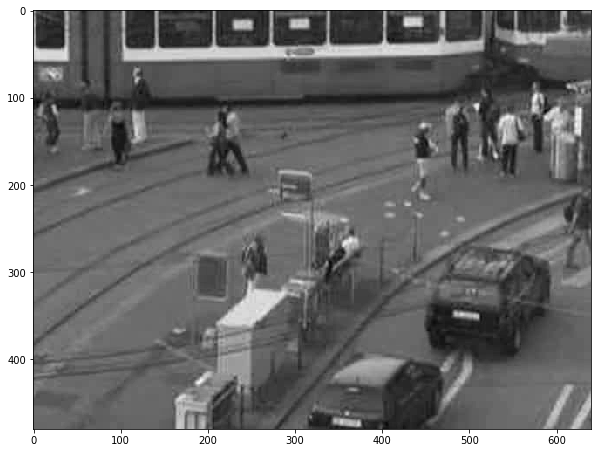

In [13]:
# filter the running average diffs and threshold

import scipy.ndimage

running_avg = np.zeros(gframes[0].shape) # frames should be grayscale
running_diff_avg = np.zeros(gframes[0].shape)
running_avgs = []
print(running_diff_avg.shape)
#print(len(frames))
alpha = 0.1
for i in range(1,len(frames)):
    running_avg = (alpha*gframes[i]+(1-alpha)*running_avg)
    running_avgs.append(running_avg)
    if i==0 or i==50 or i==100:
        plt.figure(figsize=(10,10))
        plt.imshow(running_avg,cmap='gray')
        plt.show()
        
plt.figure(figsize=(10,10))
plt.imshow(running_avg,cmap='gray')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(gframes[0],cmap='gray')
plt.show()
#maximum = np.max(np.array(diffs_filtered))
#minimum = np.min(np.array(diffs_filtered))

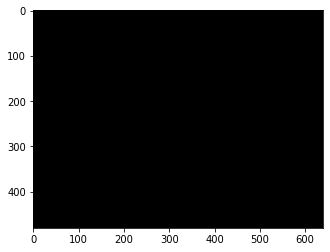

In [40]:
foreground = []

for i in range(1, len(gframes)-1):
    #print(i)
    #print(frames[i])
    #print(running_avgs[i])
    frame = running_avgs[i]-gframes[i]
    #print(frame.shape)
    for p in range(frame.shape[0]):
        for q in range(frame.shape[1]):
            if frame[p][q]<30:
                frame[p][q]=0
            else:
                frame[p][q]=255
    foreground.append(frame)

plt.imshow(foreground[1],cmap="gray")
    #Literally just difference frame and average and threshold result (45 good?)
filename="foreground.mp4"
forec = foreground.copy()
for a in range(len(foreground)):
    forec[a] = foreground[a].astype(np.uint8)
write_data_dir = '/dcs/16/u1606521/year4/cs413/data/' # some folder where you want to save the file
write_frames(forec,  write_data_dir + filename)

## Gaussian Background Model

The running average background model has 1 parameter for each pixel: 
    its average over a time window (determined by $ \alpha $).
    
The Gaussian Background Model usese the learning rule to keep a second statistic in addition to 
the *mean* value, namely the *variance*. Beacause variances are additive, we can use the same
learning rule:
    
$$
    M(t) = \alpha  f(t) + (1 - \alpha) M(t-1)\\
    V(t) = \alpha  (f(t) - M(t))^2 + (1 - \alpha) V(t-1)
$$
This time, the running average (mean) is $ M(t) $, and the variance is $ V(t) $. Note how we calculate the
variance as the square of the difference of the current frame from the mean.

In Python you might write it like this:
~~~~
    mean = alpha * frames_g[i] + (1.0 - alpha) * mean
    var = alpha * np.square(frames_g[i] - mean) + (1.0 - alpha) * var
~~~~

### Exercises 3

1. Implement a running Gaussian Model and display the mean and variance images at frames 0, 50, 100. Store the means and variances calculated at each step.

2. Write the mean and variances to a movie file and visualise these over a sequence.

3. To use the model to separate out foreground from background, we need to implement the following
decision threshold:
$$
        (f(t) - M(t-1))^2 > K V(t-1)
$$
Where $ K $ is something like $ 2 $, $ 2.5 $ or $ 3 $. What this is saying is which pixels differences
from the running average $ M(t) $ are bigger than the local variance $ V(t) $ under the Gaussian distribution.
So this is a test of *significance* on a per pixel basis. 

Hint: you can threshold each frame to estimate the foreground like this:

~~~~
    thresh = np.zeros(frames_g[0].shape, dtype='uint8')
    thresh[frame_var > K * vars[i]] = 255
~~~~

4. Test out your implementation on `pedestrians.mp4`, `roundabout.mp4` and `vtest.m4v`. What do you discover?

(480, 640)
379


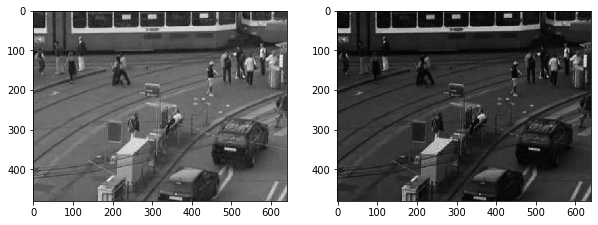

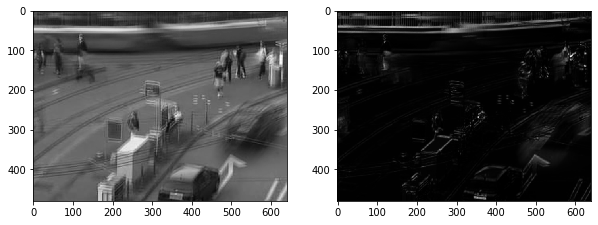

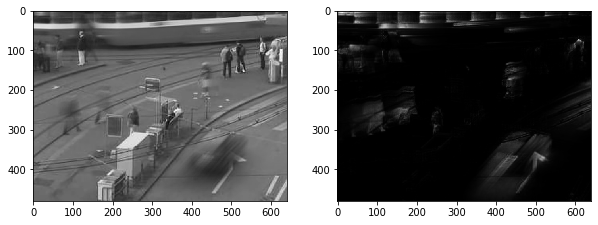

done


In [53]:
mean = np.zeros(gframes[0].shape)# frames should be grayscale
var = np.zeros(gframes[0].shape)
running_avgs = []
running_vars = []
print(running_diff_avg.shape)
#print(len(frames))
alpha = 0.1
print(len(gframes))
for i in range(1,len(gframes)):
    mean = alpha * gframes[i] + (1.0 - alpha) * mean
    var = alpha * np.square(gframes[i] - mean) + (1.0 - alpha) * var
    running_avgs.append(mean)
    running_vars.append(var)
    if i==1 or i==51 or i==101:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(mean,cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(var,cmap='gray')
        plt.show()
filename="means.mp4"
fixed_avgs = []
fixed_vars=[]
for p in running_avgs:
    fixed_avgs.append(p.astype(np.uint8))
for q in running_vars:
    fixed_vars.append(q.astype(np.uint8))
write_frames(fixed_avgs,  write_data_dir + filename)
filename = "vars.mp4"
write_frames(fixed_vars,  write_data_dir + filename)
print("done") 


In [68]:
tframes = gframes.copy()
K = 2
for i in range(1,len(gframes)-1):
    thresh = np.zeros(gframes[0].shape, dtype='uint8')
    #print(running_vars[i] > K * running_vars[i])
    thresh[(gframes[i]-running_avgs[i-1])**2 > K * running_vars[i-1]] = 255
    tframes[i-1] = thresh
filename = "tframes.mp4"
write_frames(tframes,  write_data_dir + filename)
print("done")

done


## OpenCV Mixture of Gaussians Bacground Subtraction 

It is not surpring to learn that OpenCV has an implementation of background subtraction using
Mixture of Gaussians (similar to the Stauffer and Grimson method we discussed in class.)

To use this method is very simple to use.

1. First create a MOG background subtractor class
~~~~
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
~~~~

2. Pass frames to it using the `apply()` method and store the returned binary mask:

~~~~
fgmask = fgbg.apply(frame)
~~~~

### Exercises 4

1. Use the OpenCV MOG background subtraction on the `vtest.m4v` sequence.

2. Display some of the foreground masks.

3. Use connected component labelling to find bounding boxes of the objects in the scene (mostly people).

4. Overlay the bounding boxes on the original sequence and write out these as a movie.

Note that you can add rectangles to a plot like this:

~~~~
import matplotlib.patches as patches
    
for i in ... # all frames

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ... # extract foreground fgmask
    
    
    comps = measure.label(fgmask, background=0) # connected component image

    ax.imshow(frame)
    
    
    for ... # each connected component label l
        bb = bounding_box(comps, label=l) # bounding box for a given label

        rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1],edgecolor='r')

        ax.add_patch(rect)
    

    plt.show()
~~~~

